# Objective
This is part of the Kaggle dataset for the Titanic disaster.  In a way, this is the "Hello World" of ML, and we will use this project to explore different approaches of using the data.

One of the initial key task would be to perform an EDA and clean up the data.

The data can be downloaded from the [Kaggle Titanic Competition](https://www.kaggle.com/c/titanic/data) site.  

After it is downloaded, put it into your Colab Notebooks folder, under "data/kaggle/titanic/".  Feel free to tweak this parameter if needed.

# Environment Setup


## Import necessary libraries

In [1]:
%tensorflow_version 2.x

In [2]:
import os
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt


## Data intake

In [3]:
# Native method - using Google Drive Colab - just tweak IN_DIR to whereever you
# have stored the CSV files
drive.mount('/content/gdrive')
IN_DIR = os.path.join('/content/gdrive', 'My Drive', 'Colab Notebooks', 'data', 'kaggle', 'titanic')

# Define the files here
file_train = os.path.join(IN_DIR, 'train.csv')
file_test = os.path.join(IN_DIR, 'test.csv')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
df_train = pd.read_csv(file_train)
df_test = pd.read_csv(file_test)

## Initial EDA on training data

## Let's take in some of the helper functions defined in Kaggle - you can find them [here](https://www.kaggle.com/raenish/cheatsheet-text-helper-functions)

In [5]:
def missing_value_of_data(data):
    total=data.isnull().sum().sort_values(ascending=False)
    percentage=round(total/data.shape[0]*100,2)
    return pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])

def count_values_in_column(data,feature):
    total=data.loc[:,feature].value_counts(dropna=False)
    percentage=round(data.loc[:,feature].value_counts(dropna=False,normalize=True)*100,2)
    return pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])

def unique_values_in_column(data,feature):
    unique_val=pd.Series(data.loc[:,feature].unique())
    return pd.concat([unique_val],axis=1,keys=['Unique Values'])

def duplicated_values_data(data):
    dup=[]
    columns=data.columns
    for i in data.columns:
        dup.append(sum(data[i].duplicated()))
    return pd.concat([pd.Series(columns),pd.Series(dup)],axis=1,keys=['Columns','Duplicate count'])


In [6]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


There seems to be quite a lot of missing data in some columns (Age, Cabin, Embarked (small numbers)).  Let's use the helper function to find out more.

In [8]:
result = missing_value_of_data(df_train)
result[result.Total > 0]


,Total,Percentage
Cabin,687,77.10
Age,177,19.87
Embarked,2,0.22


In [9]:
df_train[df_train.Cabin.notnull()].Cabin

1              C85
3             C123
6              E46
10              G6
11            C103
          ...     
871            D35
872    B51 B53 B55
879            C50
887            B42
889           C148
Name: Cabin, Length: 204, dtype: object

TODO: We need to better understand the cabin structure.  I believe we can do some feature engineering on this.  And is there a way to better estimate the cabins for the miss data, which is missing 77.1% of the data.

In [10]:
df_train[df_train.Age.isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
19,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
26,27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q
...,...,...,...,...,...,...,...,...,...,...,...,...
859,860,0,3,"Razi, Mr. Raihed",male,NaN,0,0,2629,7.2292,NaN,C
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.5500,NaN,S
868,869,0,3,"van Melkebeke, Mr. Philemon",male,NaN,0,0,345777,9.5000,NaN,S
878,879,0,3,"Laleff, Mr. Kristo",male,NaN,0,0,349217,7.8958,NaN,S


Age is missing from a large portion of the data (19.87%).  There are a few ways of doing it, with differing difficulty levels:

1. Simply take a mean/median across the data set
2. Split by male/female, and take the mean/median
3. Use the features of titles in the names, before taking a mean/media (probably work better for females as it tells whether they are married from the title)
4. Use Parch to estimate (though this is not likely conclusive as they do not necessarily have to travel with parents / child - plus you won't know whether they are the parent or the child to begin with)
5. Use Pclass to as an estimate?

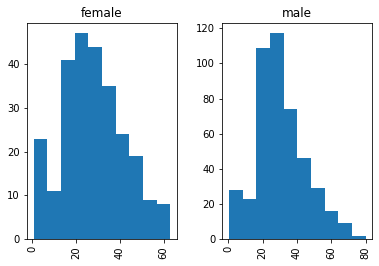

In [11]:
# Before imputation
df_train.hist(by='Sex', column='Age')
plt.show()

## Method 2 - Split by median (for each sex)
Likely problem with this approach would naturally be the fact that the cases within the age group will be skewed in the model

In [12]:
# Simple method - Age_Median by male / female
for gender in ['male', 'female']:
  age_median = df_train[df_train.Age.notnull()].pivot_table(index='Sex', aggfunc='median').Age.loc[gender]
  #age_median_female = age_median.loc['female']
  mask_empty_age = (df_train.Sex == gender) & (df_train.Age.isnull())
  df_train.loc[df_train[mask_empty_age].index, 'Age'] = age_median

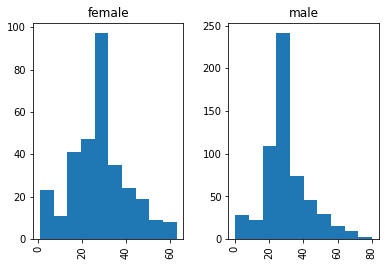

In [13]:
# After imputation
df_train.hist(by='Sex', column='Age')
plt.show()

In [14]:
result = missing_value_of_data(df_train)
result[result.Total > 0]

,Total,Percentage
Cabin,687,77.10
Embarked,2,0.22


In [15]:
df_train[df_train.Cabin.isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,29.0,0,0,330877,8.4583,NaN,Q
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
884,885,0,3,"Sutehall, Mr. Henry Jr",male,25.0,0,0,SOTON/OQ 392076,7.0500,NaN,S
885,886,0,3,"Rice, Mrs. William (Margaret Norton)",female,39.0,0,5,382652,29.1250,NaN,Q
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,27.0,1,2,W./C. 6607,23.4500,NaN,S


# For now, we just drop the Cabin feature in this model

In [16]:
# No code here for now - implement other feature engineering in the future versions
pass

# Extract title from Name


In [17]:
df_train['Title'] = df_train.Name.str.extract(r'^.+?,\s*(\w+\.)')
df_train[['Name', 'Title']].head(20)

,Name,Title
0,"Braund, Mr. Owen Harris",Mr.
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",Mrs.
2,"Heikkinen, Miss. Laina",Miss.
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",Mrs.
4,"Allen, Mr. William Henry",Mr.
5,"Moran, Mr. James",Mr.
6,"McCarthy, Mr. Timothy J",Mr.
7,"Palsson, Master. Gosta Leonard",Master.
8,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",Mrs.
9,"Nasser, Mrs. Nicholas (Adele Achem)",Mrs.


In [18]:
df_train.Title.value_counts()

Mr.          517
Miss.        182
Mrs.         125
Master.       40
Dr.            7
Rev.           6
Major.         2
Col.           2
Mlle.          2
Jonkheer.      1
Don.           1
Mme.           1
Sir.           1
Ms.            1
Lady.          1
Capt.          1
Name: Title, dtype: int64

We can probably combine a few of the entries that are coded in other languages (e.g. Ms. = Miss, Mlle = Miss, Mme = Mrs.)

In [19]:
# Drop the columns that we will not be using
df_train.drop(columns=['Name', 'Cabin'], axis=1, inplace=True)

In [20]:
df_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title
0,1,0,3,male,22.0,1,0,A/5 21171,7.2500,S,Mr.
1,2,1,1,female,38.0,1,0,PC 17599,71.2833,C,Mrs.
2,3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,S,Miss.
3,4,1,1,female,35.0,1,0,113803,53.1000,S,Mrs.
4,5,0,3,male,35.0,0,0,373450,8.0500,S,Mr.


In [21]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    object 
 4   Age          891 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Ticket       891 non-null    object 
 8   Fare         891 non-null    float64
 9   Embarked     889 non-null    object 
 10  Title        890 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 76.7+ KB


In [ ]:
df_train

# Initial visual analysis

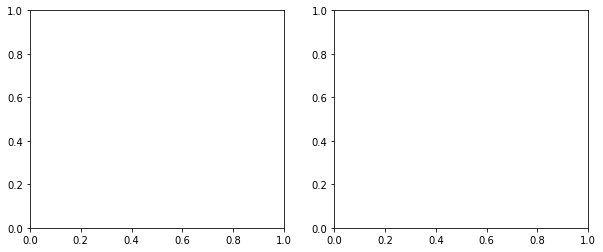

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))